# J2118 SED analysis

In [13]:
import os, time, pdb
import numpy as np

#### Plotting preferences

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks', font_scale=1.8, palette='Set2')
%matplotlib inline

In [15]:
from prospect.models.templates import TemplateLibrary
#TemplateLibrary.describe('alpha')

In [16]:
from prospect.io import read_results as reader

In [17]:
result, obs, _ = reader.results_from('J2118-delayed-tau.h5', dangerous=False)
print(result.keys())

dict_keys(['model_params', 'optimizer_duration', 'paramfile_text', 'prospector_version', 'run_params', 'chain', 'efficiency', 'information', 'lnlikelihood', 'lnprobability', 'logvol', 'logz', 'logzerr', 'niter', 'samples_id', 'weights', 'ncall', 'sampling_duration', 'theta_labels', 'obs', 'model', 'optimization_results'])


In [20]:
from hizea.prospector import load_model, load_sps
model = load_model('delayed-tau', redshift=0.535)
%time sps = load_sps()

CPU times: user 85 µs, sys: 0 ns, total: 85 µs
Wall time: 90.8 µs


In [21]:
print(model)

:::::::
<class 'prospect.models.sedmodel.SedModel'>

Free Parameters: (name: prior) 
-----------
  logmass: <class 'prospect.models.priors.TopHat'>(mini=10.0,maxi=12.0)

Fixed Parameters: (name: value [, depends_on]) 
-----------
  zred: 0.535 
  mass: 100000000000.0 <function logmass2mass at 0x1058da8c8>
  logzsol: 0.2 
  dust2: 1.0 
  sfh: 4 
  tage: 1.0 
  imf_type: 2 
  dust_type: 0 
  tau: 10.0 
  add_dust_emission: True 
  duste_umin: 1.0 
  duste_qpah: 4.0 
  duste_gamma: 0.001 


In [22]:
obs['maggies']/obs['maggies_unc']

array([ 6.19166442, 38.33462908, 15.8078658 , 43.73985402, 46.67888997,
       45.03520046, 21.58947261, 57.96556272, 57.55742846, 70.47767591,
       38.32737699, 15.51807486,  6.04602911])

In [39]:
ang2micron = 1e-4 # Angstrom --> micron
maggies2mJy = 10**(0.4*16.4) # maggies --> mJy

def _galaxyphot(obs):
    """Get the galaxy photometry and inverse variances (converted to mJy) and filter
    effective wavelengths (converted to microns).

    """
    weff = np.array([f.wave_effective for f in obs['filters']]) * ang2micron
    fwhm = np.array([f.effective_width for f in obs['filters']]) * ang2micron

    galphot = obs['maggies'] * maggies2mJy
    galphoterr = obs['maggies_unc'] * maggies2mJy

    return weff, fwhm, galphot, galphoterr

def _sed(model, theta, obs, sps):
    """Construct the SED for a given set of parameters.  Divide by mextra to account
    for the *current* mass in stars (rather than the integrated stellar mass
    based on the SFH.

    Also convert wavelengths from Angstroms to microns and fluxes from maggies
    to mJy.

    """
    modelwave = sps.wavelengths * (1 + obs['redshift']) # [observed-frame wavelengths]
    modelwave *= ang2micron
    
    modelspec, modelphot, mextra = model.mean_model(theta, obs, sps=sps)
    modelspec *= maggies2mJy
    modelphot *= maggies2mJy
    #print(modelphot)
    
    return modelwave, modelspec, modelphot

def bestfit_sed(obs, chain=None, lnprobability=None, theta=None, sps=None,
                model=None, seed=None, nrand=100):
    """Plot the (photometric) best-fitting SED.

    Either pass chain and lnprobability (to visualize the emcee fitting results)
    *or* theta (to visualize just a single SED fit).

    """
    rand = np.random.RandomState(seed)

    # Get the galaxy photometry and filter info.
    weff, fwhm, galphot, galphoterr = _galaxyphot(obs)

    # Build the maximum likelihood model fit and also grab a random sampling of
    # the chains with weight equal to the posterior probability.    
    if chain is not None:
        if chain.ndim == 3: # emcee
            nwalkers, niter, nparams = chain.shape
            ntot = nwalkers * niter
            flatchain = chain.reshape(ntot, nparams)
            lnp = lnprobability.reshape(ntot)
        else: # dynesty
            ntot, nparams = chain.shape
            flatchain = chain
            lnp = lnprobability
            
        theta = flatchain[lnp.argmax(), :] # maximum likelihood values
        print(theta)

        prob = np.exp(lnp - lnp.max())
        prob /= prob.sum()
        rand_indx = rand.choice(ntot, size=nrand, replace=False, p=prob)
        theta_rand = flatchain[rand_indx, :]
        
    modelwave, modelspec, modelphot = _sed(model=model, theta=theta, obs=obs, sps=sps)

    # Establish the wavelength and flux limits.
    minwave, maxwave = 0.05, 20.0
    #minwave, maxwave = np.min(weff - 5*fwhm), np.max(weff + fwhm)

    inrange = (modelwave > minwave) * (modelwave < maxwave)
    #maxflux = np.hstack( (galphot + 3*galphoterr, modelspec[inrange]) ).max() * 1.05
    #minflux = -0.05 * maxflux

    fig, ax = plt.subplots(figsize=(12, 8))
    if chain is not None and nrand > 0:
        for ii in range(nrand):
            print(theta_rand[ii, :])
            _, r_modelspec, _ = _sed(model=model, theta=theta_rand[ii, :], obs=obs, sps=sps)
            ax.plot(modelwave, r_modelspec, alpha=0.2, color='gray')
    ax.plot(modelwave, modelspec, alpha=1.0, label='Model spectrum')
    
    ax.errorbar(weff, modelphot, marker='s', ls='', lw=3, markersize=20, markerfacecolor='none',
                markeredgewidth=3, alpha=0.8, label='Model photometry')
    ax.errorbar(weff, galphot, yerr=galphoterr, marker='o', ls='', lw=3, markersize=10,
                markeredgewidth=3, alpha=0.8, label='Observed photometry')
                
    ax.set_xlabel(r'Observed-frame Wavelength (${}$m)'.format('\mu'))
    ax.set_ylabel('Flux Density (mJy)')
    ax.set_xlim(minwave, maxwave)
    #ax.set_ylim(minflux, maxflux)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend(loc='upper right', fontsize=16, frameon=True)
    #plt.subplots_adjust(left=0.1, right=0.95, bottom=0.12, top=0.95)
    #return fig

[11.08969923]


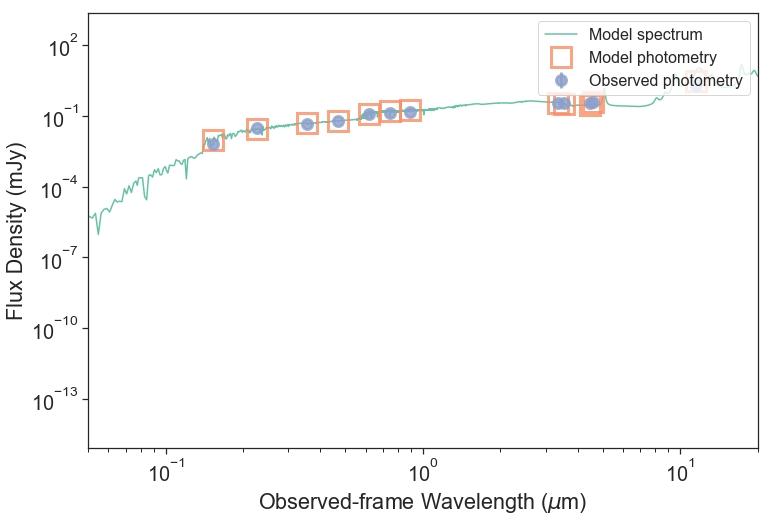

In [40]:
bestfit_sed(obs, chain=result['chain'], lnprobability=result['lnprobability'], 
            sps=sps, model=model, seed=1, nrand=0)

[1.04473689]
Maximum likelihood values: [1.04473689]


<ErrorbarContainer object of 3 artists>

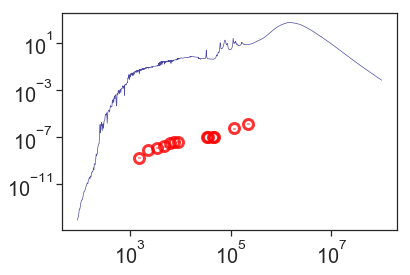

In [11]:
imax = np.argmax(result['lnprobability'])
theta_max = result["chain"][imax, :]
print(theta_max)
print('Maximum likelihood values: {}'.format(theta_max))

#theta_max[0] = np.log10(theta_max[0])
mspec, mphot, mextra = model.mean_model(theta_max, obs, sps=sps)
wspec = sps.wavelengths * (1.0 + model.params.get('zred'))
wphot = obs["phot_wave"]
plt.loglog(wspec, mspec, label='Model spectrum (random draw)',
           lw=0.7, color='navy', alpha=0.7)
plt.errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'], 
         label='Observed photometry', ecolor='red', 
         marker='o', markersize=10, ls='', lw=3, alpha=0.8, 
         markerfacecolor='none', markeredgecolor='red', 
         markeredgewidth=3)

In [ ]:
# randomly chosen parameters from chain
randint = np.random.randint
theta = result["chain"][randint(len(result["chain"]))]

# generate models
#sps = reader.get_sps(result)  # this works if using parameter files
mspec, mphot, mextra = model.mean_model(theta, obs, sps=sps)
mspec_map, mphot_map, _ = model.mean_model(theta_max, obs, sps=sps)

wspec = sps.wavelengths * (1.0 + model.params.get('zred'))
wphot = obs["phot_wave"]

xmin, xmax = np.min(wphot)*0.8, np.max(wphot)/0.8
temp = np.interp(np.linspace(xmin,xmax,10000), wspec, mspec)
ymin, ymax = temp.min()*0.8, temp.max()/0.4

# Make plot of data and model
fig, ax = plt.subplots(figsize=(12, 8))

ax.loglog(wspec, mspec, label='Model spectrum (random draw)',
       lw=0.7, color='navy', alpha=0.7)
ax.loglog(wspec, mspec_map, label='Model spectrum (MAP)',
       lw=0.7, color='green', alpha=0.7)
ax.errorbar(wphot, mphot, label='Model photometry (random draw)',
         marker='s', markersize=10, alpha=0.8, ls='', lw=3, 
         markerfacecolor='none', markeredgecolor='blue', 
         markeredgewidth=3)
ax.errorbar(wphot, mphot_map, label='Model photometry (MAP)',
         marker='s', markersize=10, alpha=0.8, ls='', lw=3, 
         markerfacecolor='none', markeredgecolor='green', 
         markeredgewidth=3)
ax.errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'], 
         label='Observed photometry', ecolor='red', 
         marker='o', markersize=10, ls='', lw=3, alpha=0.8, 
         markerfacecolor='none', markeredgecolor='red', 
         markeredgewidth=3)

ax.set_xlabel('Wavelength [A]')
ax.set_ylabel('Flux Density [maggies]')
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
ax.legend(loc='best', fontsize=20)
plt.tight_layout()

In [ ]:
cornerfig = reader.subcorner(result, start=0, thin=1, fig=plt.subplots(5,5,figsize=(27,27))[0])

In [ ]:
tracefig = reader.traceplot(result, figsize=(20,10))

In [ ]:
stop

In [ ]:
TemplateLibrary.describe('burst_sfh')

In [ ]:
TemplateLibrary.describe('parametric_sfh')

In [ ]:
model = load_model('delayed-tau', redshift=obs['redshift'])
model.theta_labels

In [ ]:
%time theta_best = max_likelihood(run_params, model, obs, sps, verbose=True, seed=seed)

In [ ]:
def qa_sed(theta_best, model, obs, sps):
    
    pspec, pphot, pextra = model.mean_model(theta_best, obs, sps=sps)

    wphot = obs['phot_wave']
    wspec = sps.wavelengths * (1.0 + model.params.get('zred'))

    xmin, xmax = np.min(wphot)*0.5, np.max(wphot)/0.5
    temp = np.interp(np.linspace(xmin, xmax, 10000), wspec, pspec)
    ymin, ymax = temp.min()*0.8, temp.max()/0.4    
    
    fig, ax = plt.subplots(figsize=(12, 8))

    ax.loglog(wspec, pspec, label='Model spectrum', lw=0.7, color='navy', alpha=0.7)
    ax.errorbar(wphot, pphot, label='Model photometry', marker='s', markersize=10, 
                alpha=0.8, ls='', lw=3, markerfacecolor='none', markeredgecolor='blue', 
                markeredgewidth=3)
    ax.errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'], label='Observed photometry', 
                marker='o', markersize=10, alpha=0.8, ls='', lw=3, ecolor='red', 
                markerfacecolor='none', markeredgecolor='red', 
                markeredgewidth=3)

    ax.set_xlabel(r'Observed-frame Wavelength ($\mu$m)')
    ax.set_ylabel('Flux Density [maggies]')
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    ax.legend(loc='best', fontsize=20)
    plt.tight_layout()

In [ ]:
qa_sed(theta_best, model, obs, sps)

In [ ]:
wspec